# Evaulating Uplift Models

INTRO

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *

In [3]:
def generate_data(N=5000, seed=1, true_te=False):
    np.random.seed(seed)

    # Control 1: subscriber
    x1 = np.random.binomial(1, 0.4, N)
    
    # Control 2: age
    x2 = np.round(np.random.uniform(20, 60, N), 2)
    
    # Control 3: past sales
    effect_x1 = 0.2
    x3_ = -1.45 + (100/x2) - np.maximum((x2-60)**2/500, 0) + effect_x1*x1 
    x3 = np.maximum(np.random.normal(x3_, 0.01), 0)
    
    # Treatment: mail
    w = np.random.binomial(1, 0.2 + 0.6*(1-x1))
    
    # Treatment effect
    tau = -0.05*(x2<30) + 0.08*(x2>45)

    # Null potential outcome: sales
    y0 = np.maximum(np.random.normal(x3_, 0.05, N), 0)
    
    # Generate the dataframe
    df = pd.DataFrame({'new': x1, 'age': x2, 'sales_old': x3, 'mail': w, 'sales': y0 + w*tau})

    # Add truth
    if true_te:
        df['sales1'] = np.maximum(y0 + tau, 0)
        df['sales0'] = np.maximum(y0, 0)
        df['effect'] = tau
        df['mu1'] = np.maximum(x3_ - effect_x1*x1 + tau, 0)
        df['mu0'] = np.maximum(x3_ - effect_x1*x1, 0)

    return round(df, 3)

In [43]:
df = generate_data()
df.head()

,new,age,sales_old,mail,sales
0,0,47.15,0.333,1,0.407
1,1,50.57,0.560,0,0.473
2,0,21.29,0.258,1,0.212
3,0,59.29,0.242,1,0.420
4,0,23.65,0.141,0,0.208


We have information on 500 customers, for whom we observe whether they are `new` customers, their `age`, the sales they generated before the email campaign (`sales_old`), whether they were sent the `mail`, and the `sales` after the email campaign.

The **outcome** of interest is `sales`, which we denote with the letter *Y*. The **treatment** or policy that we would like to improve is the `mail` campaign, which we denote with the letter *W*. We call all the remaining variables **confounders** or control variables and we denote them with *X*.

In [5]:
Y = 'sales'
W = 'mail'
X = ['age', 'sales_old', 'new']

The Dyrected Acyclic Graph (DAG) behind the data generate process can be represented as follows.

```mermaid
flowchart TD
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:3px;

W((mail))
Y((sales))
X1((new))
X2((age))
X3((sales old))

Z --> Y
X1 --> W
W --> Y
X1 --> Y
X2 --> Y
X3 --> Y

class W,Y,X1,X2,X3 included;

linkStyle 0 stroke:#2db88b,stroke-width:6px;
linkStyle 1,2,3,4,5 stroke:#003f5c,stroke-width:6px;
```

In [ ]:
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV

model_y = RandomForestRegressor(max_depth=2)
model_e = LogisticRegressionCV()
model_tau = RandomForestRegressor(max_depth=2)

## Uplift Models

There exist **many methods** to model uplift or, in other words, to estimate Conditional Average Treatment Effects. Since the objective of this article is not to compare uplift models but methods to evaluate uplift models, we will not explain the models in detail. For a gentle introduction, you can check [my article on meta learners](https://medium.com/towards-data-science/understanding-meta-learners-8a9c1e340832).

The first meta-

In [7]:
from src.learners_utils import *

In [8]:
from econml.metalearners import SLearner

S_learner = SLearner(overall_model=model_y).fit(df[Y], df[W], X=df[X])

In [10]:
from econml.metalearners import TLearner

T_learner = TLearner(models=clone(model_y)).fit(df[Y], df[W], X=df[X])

In [12]:
from econml.metalearners import XLearner

X_learner = XLearner(models=model_y, propensity_model=model_e, cate_models=model_tau).fit(df[Y], df[W], X=df[X])

In [14]:
from econml.dml import NonParamDML

R_learner = NonParamDML(model_y=model_y, model_t=model_e, model_final=model_tau, discrete_treatment=True
                       ).fit(df[Y], df[W], X=df[X])

In [16]:
from econml.dr import DRLearner

DR_learner = DRLearner(model_regression=model_y, model_propensity=model_e, model_final=model_tau
                      ).fit(df[Y], df[W], X=df[X])

## Oracle Losses

The main problem of evaluating uplift models is that, even when running an experiment and even when setting aside a validation dataset, we do **not observe** our metric of interest: the Individual Treatment Effects. Can we still do something to evaluate our estimators?

The answer is yes, but before giving more details, let's first understand what we would do if we **could observe** the Individual Treatment Effects $\tau_i$.

In [18]:
names = ['SL', 'TL', 'XL', 'RL', 'DRL']
learners = [S_learner, T_learner, X_learner, R_learner, DR_learner]

In [19]:
def compare_methods(learners, names, loss, title=None, subtitle='lower is better'):
    results = pd.DataFrame({
        'learner': names,
        'loss': [loss(learner) for learner in learners]
    })
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.barplot(data=results, x="learner", y='loss').set(ylabel='')
    plt.suptitle(title, y=1.02)
    plt.title(subtitle, fontsize=12, fontweight=None, y=0.94)
    return results

### Oracle MSE Loss

If we could observe the individual treatment effects (but we don't), we could try to measure how far our estimates $\hat{\tau}(X_i)$ are with respect to the true value $\tau_i$. This is what we normally do in machine learning when we want to evaluate a prediction method. There exist plenty of loss functions, so let's concentrate on the most popular one: the **Mean Squared Error (MSE) loss**.

$$
\mathcal{L} _ {oracle-MSE}(\hat{\tau}) = \frac{1}{n} \sum _ {i=1}^{n} \left( \hat{\tau}(X_i) - \tau(X_i) \right)^2
$$

Let's compute it across our uplift models. We compute it on a validation dataset with 10.000 observations.

In [20]:
def loss_oracle_mse(learner):
    data = generate_data(N=10_000, seed=123, true_te=True)
    tau = learner.effect(data[X])
    return np.mean((tau - data['effect'])**2)

,learner,loss
0,SL,0.003013
1,TL,0.006453
2,XL,0.000762
3,RL,0.000412
4,DRL,0.000394


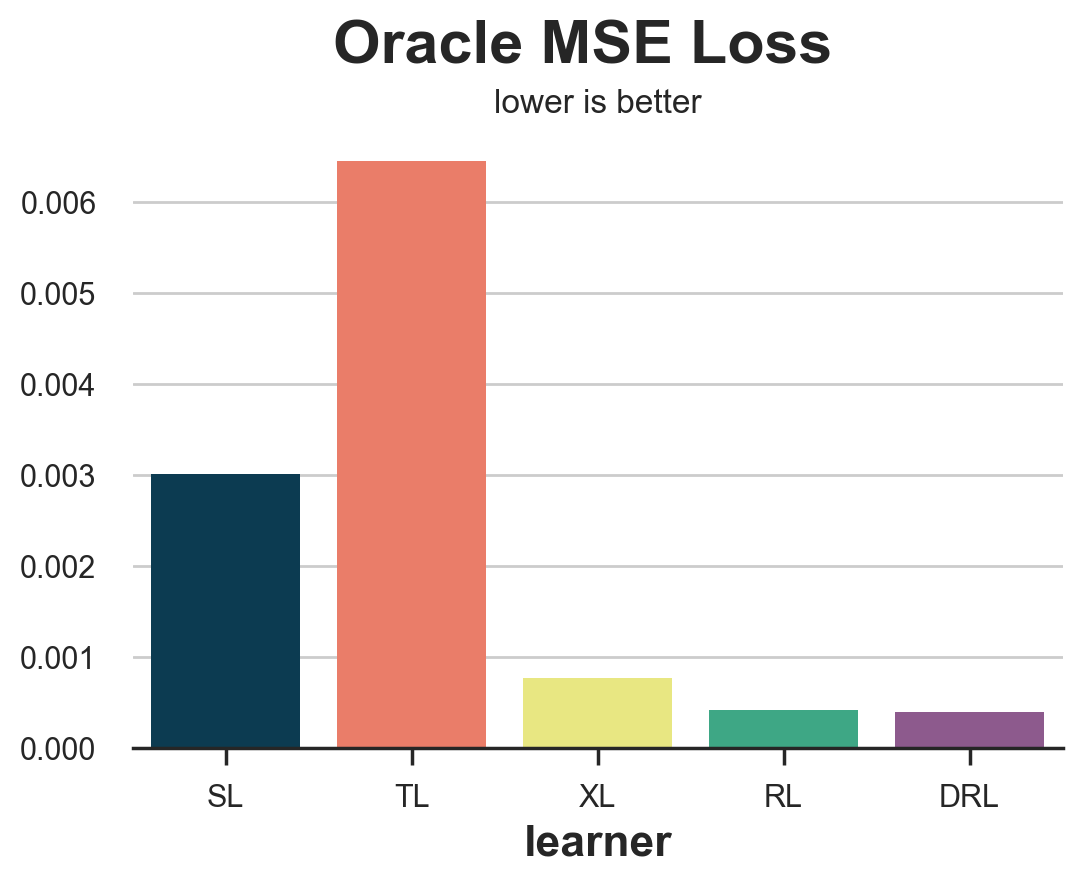

In [21]:
compare_methods(learners, names, loss_oracle_mse, title='Oracle MSE Loss')

In this case, we see that the T-learner clearly performs worst, while X-, D- and DR-learners perform best, with the R-learner slightly winning the race.

However, this might not be the best loss function. In fact, uplift modeling is just an intermediate step towards our ultimate goal: improving revenue.

### Oracle Policy Loss

Since our ultimate goal is to improve revenue, we could evaluate estimators by how much they increase revenue, given a certain policy function. Suppose, for example, that we had a $0.01\$$ cost of sending an email. Then, our policy would be to treat each costumer that has a predicted Conditional Average Treatment Effect above $0.01\$$. How much would our revenue actually increase?

$$
\mathcal{L}_{oracle-POLICY}(\hat{\tau}) = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{\tau}(X_i) - \tau(X_i) \right)^2
$$

Again, this is an "oracle" loss function that **cannot be computed** in reality since we do not observe the individual treatment effects. 

In [22]:
def loss_oracle_policy(learner):
    data = generate_data(N=10_000, seed=123, true_te=True)
    tau_hat = learner.effect(data[X])
    return np.sum(data['effect'] * (tau_hat>0.01) - 0.01)

,learner,loss
0,SL,-100.00
1,TL,4.03
2,XL,196.39
3,RL,198.64
4,DRL,198.64


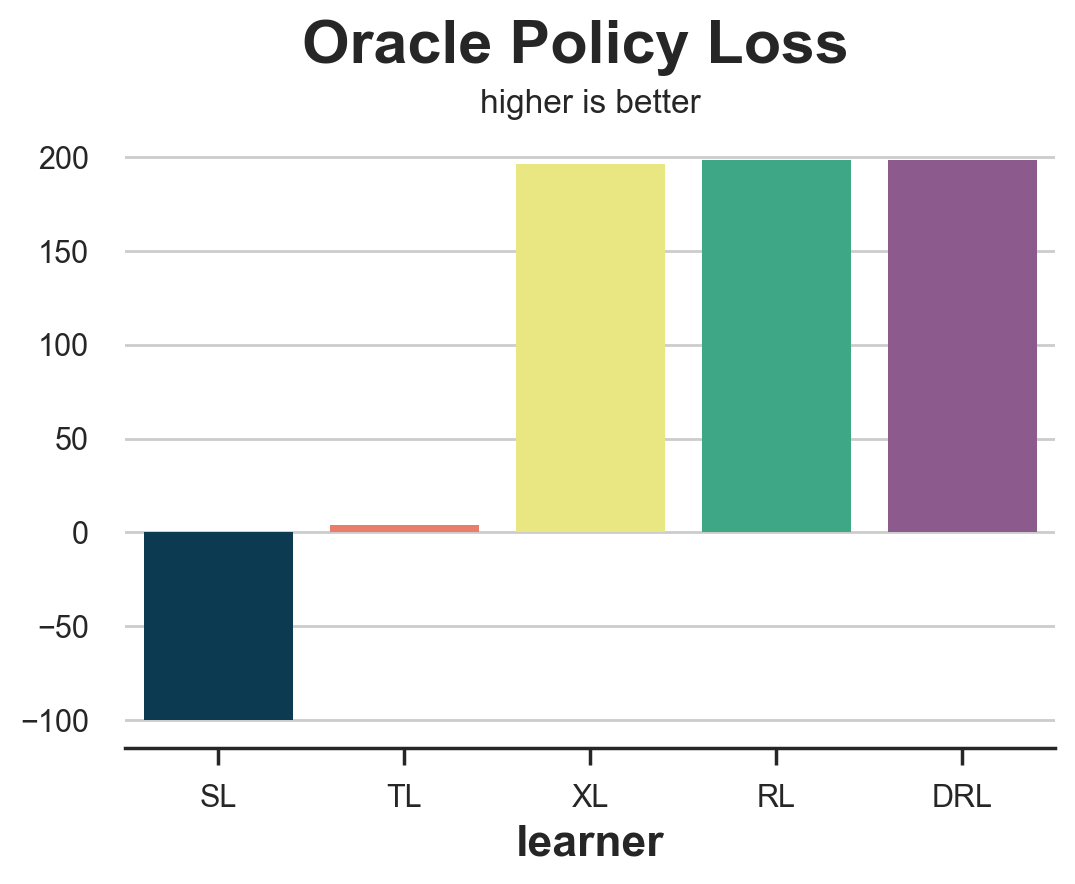

In [23]:
compare_methods(learners, names, loss_oracle_policy, title='Oracle Policy Loss', subtitle='higher is better')

In this case, the S-learner is clearly the worst performer, leading to an aggregate loss (i.e. we would have been better off not sending any email). On the other hand, X-, R- and DR- learners all lead to aggregate gains, with no clear winner

## Practical Losses

In the previous section, we have seen two examples of loss functions that we would like to compute if we could observe the Individual Treatment Effects $\tau_i$. However, in practice, even with a randomized experiment and even with a validation set, we do not observe the ITE,our object of interest. We will now cover some measures that try to evaluate uplift models, given this practical constraint.

### Outcome Loss

The first and simplest approach is to switch to a different loss variable. While we cannot observe the Individual Treatment Effects, $\tau_i$, we can still observe our outcome $y_i$. This is not exactly our object of interest, but we might expect an uplift model that performs well in terms of predicting $y$ to also produce good estimates of $\tau$.

One such loss function could be the **Outcome MSE loss**, which is the usual MSE loss function for prediction methods.

$$
\mathcal{L}_{Y}(\hat{\mu}) = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{\mu}(X_i, W_i) - Y_i \right)^2
$$

In [24]:
def loss_outcome(learner):
    data = generate_data(N=10_000, seed=123)
    mu0, mu1 = learner.predict_mu(data, X, W, Y)
    mu = mu0 * (1-data[W]) + mu1 * data[W]
    return np.mean((mu - data['sales'])**2)

,learner,loss
0,SL,0.004362
1,TL,0.004492
2,XL,0.004473
3,RL,0.003690
4,DRL,0.003729


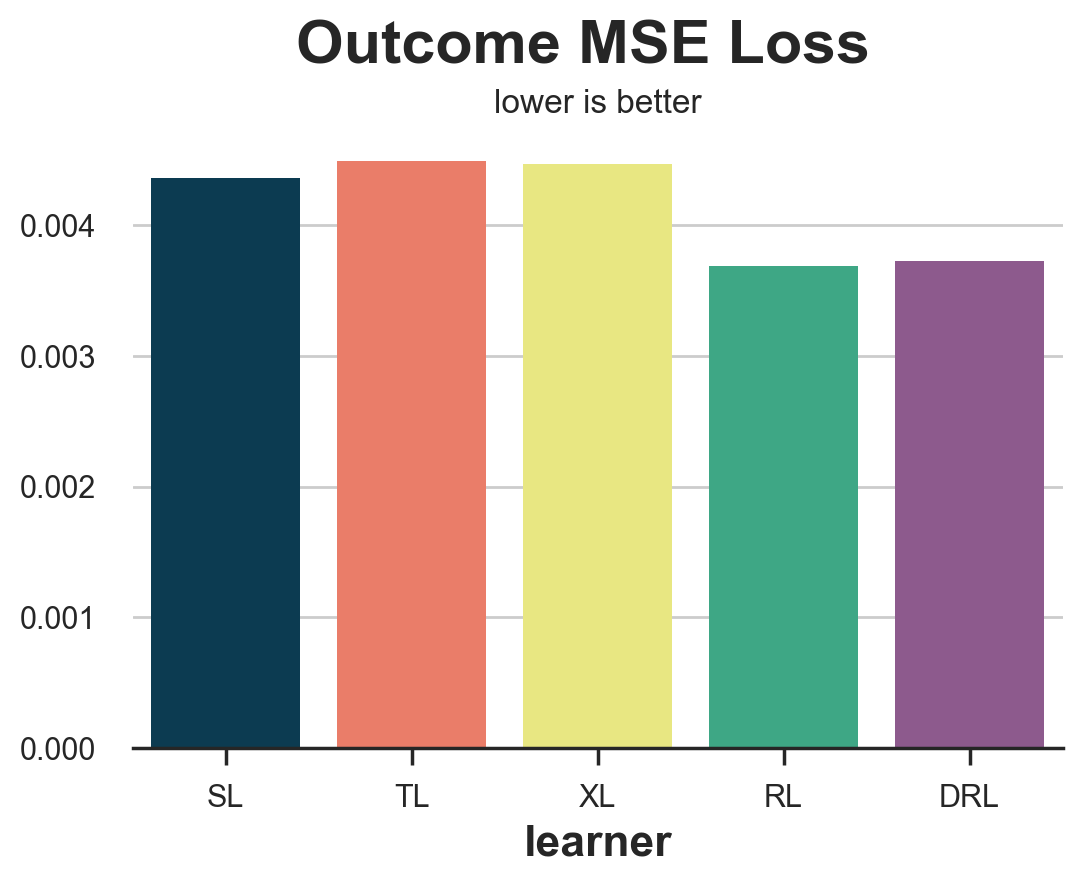

In [25]:
compare_methods(learners, names, loss_outcome, title='Outcome MSE Loss')

### Distribution Loss

In [26]:
def loss_dist(learner):
    data = generate_data(N=10_000, seed=123)
    tau = learner.effect(data[X])
    y0 = data.loc[data.mail==1, 'sales'] - tau[data.mail==1]
    return sp.stats.energy_distance(df.loc[df.mail==0, 'sales'], y0)

,learner,loss
0,SL,0.194061
1,TL,0.257276
2,XL,0.234633
3,RL,0.262204
4,DRL,0.249281


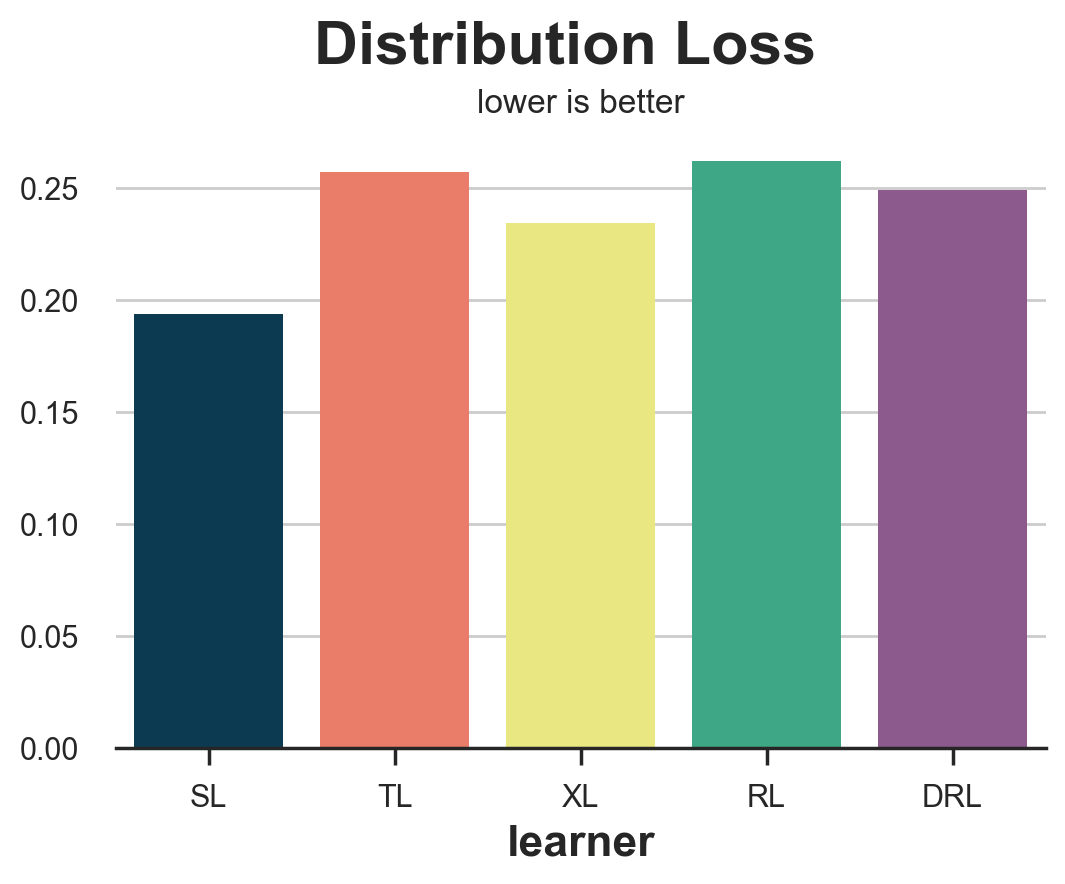

In [27]:
compare_methods(learners, names, loss_dist, 'Distribution Loss')

In [28]:
from statsmodels.formula.api import ols 

def loss_ab(learner):
    data = generate_data(N=10_000, seed=123)
    tau = learner.effect(data[X]) + np.random.normal(0, 1e-8, len(data))
    data['above_median'] = tau >= np.median(tau)
    param = ols('sales ~ mail * above_median', data=data).fit().params[-1]
    return param

,learner,loss
0,SL,0.013934
1,TL,0.151279
2,XL,0.106074
3,RL,0.088441
4,DRL,0.088679


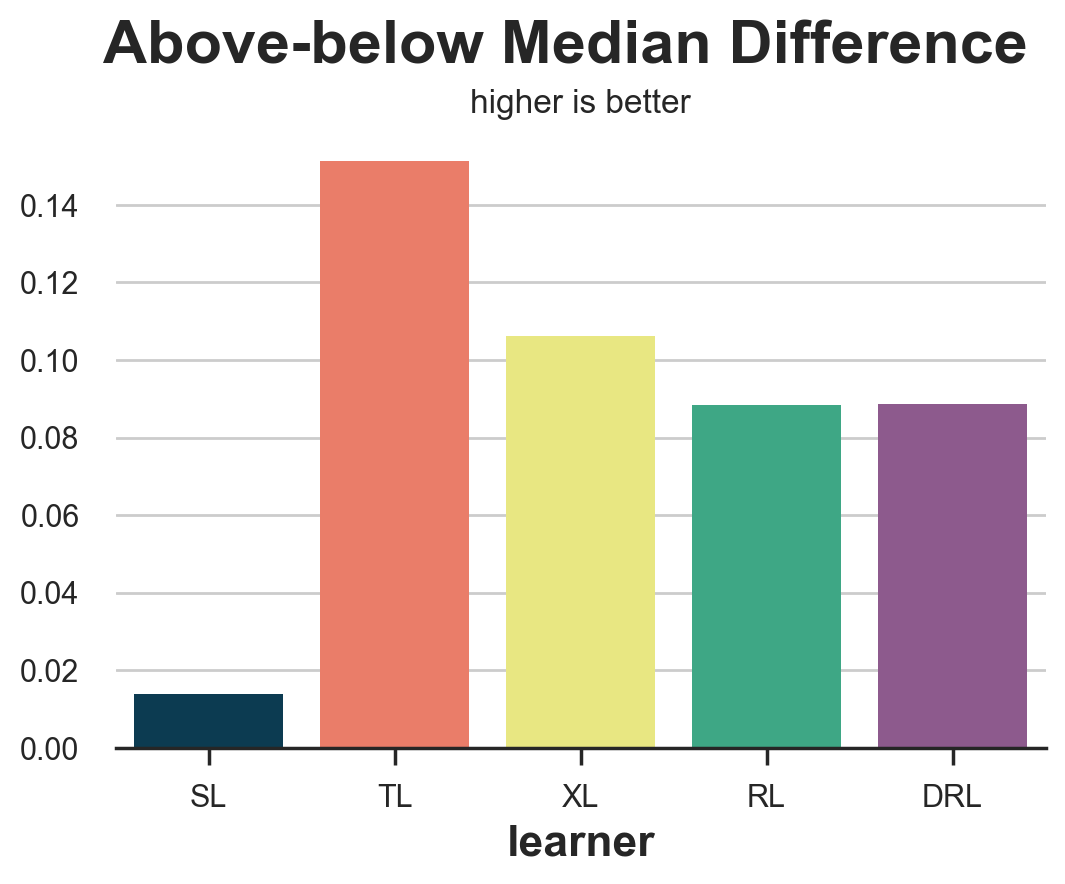

In [29]:
compare_methods(learners, names, loss_ab, title='Above-below Median Difference', subtitle='higher is better')

### Uplift Curve

Text(0.5, 0.96, 'higher is better')

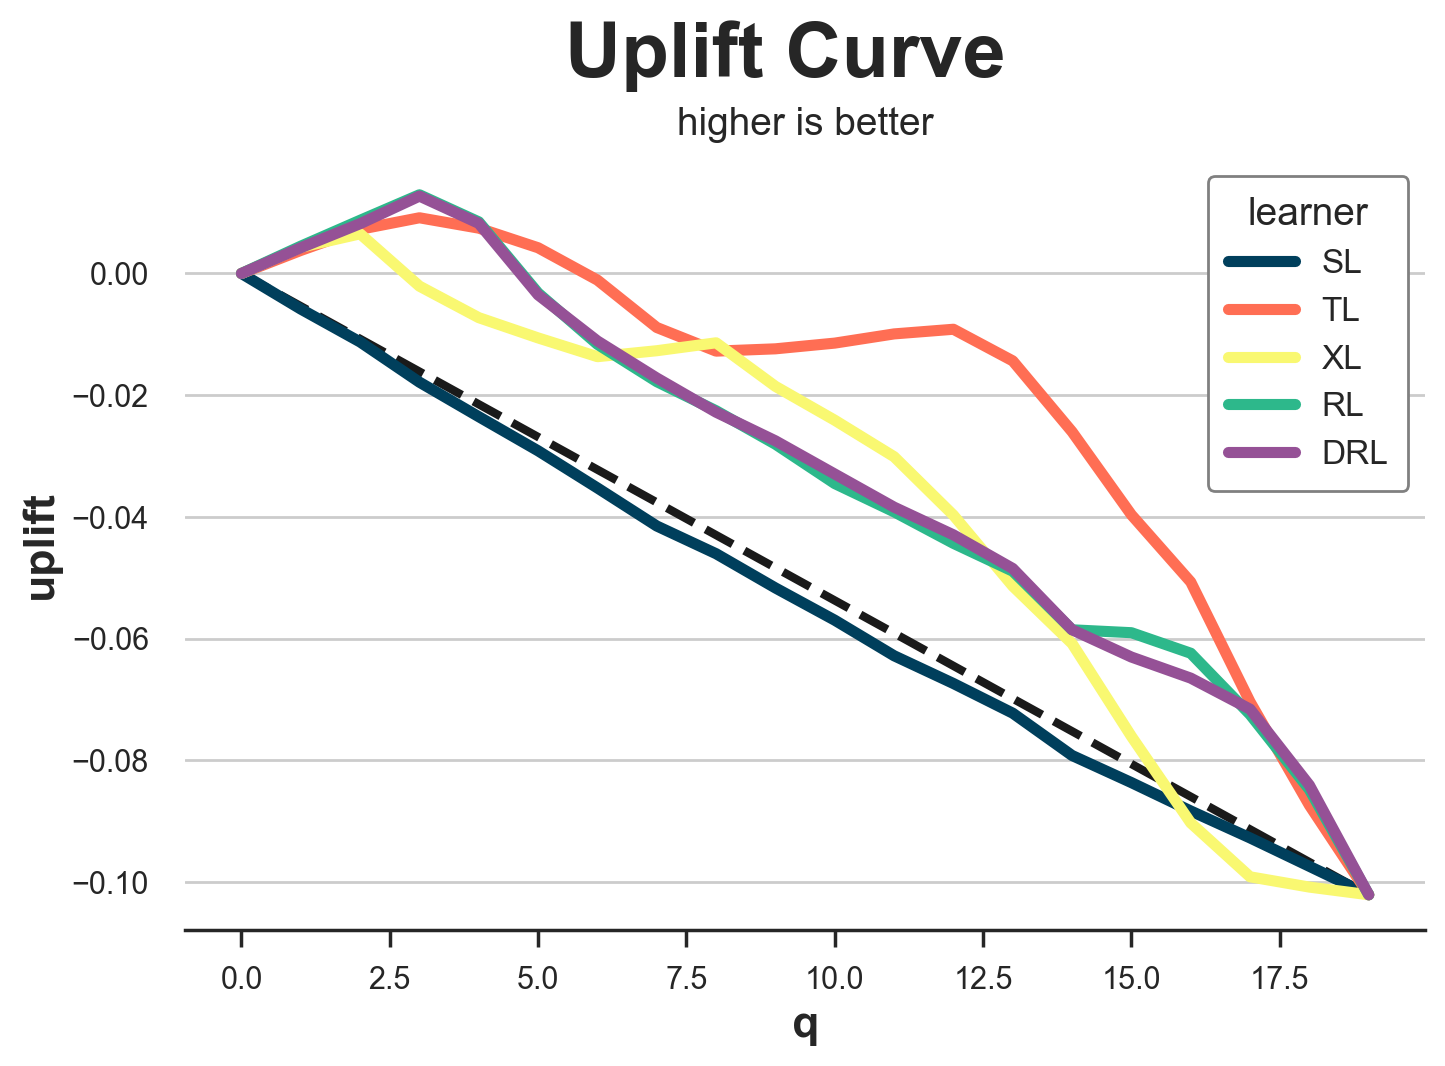

In [30]:
Q = 20
df_q = pd.DataFrame()


data = generate_data(N=10_000, seed=123)
ate = np.mean(data[Y][data[W]==1]) - np.mean(data[Y][data[W]==0])
for learner, name in zip(learners, names):
    data['tau_hat'] = learner.effect(data[X])
    data['q'] = pd.qcut(-data.tau_hat + np.random.normal(0, 1e-8, len(data)), q=Q, labels=False)
    for q in range(Q):
        temp = data[data.q <= q]
        uplift = (np.mean(temp[Y][temp[W]==1]) - np.mean(temp[Y][temp[W]==0])) * q / (Q-1)
        df_q = pd.concat([df_q, pd.DataFrame({'q': [q], 'uplift': [uplift], 'learner': [name]})])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot(x=range(Q), y=ate*range(Q)/(Q-1), color='k', ls='--', lw=3)
sns.lineplot(x='q', y='uplift', hue='learner', data=df_q);
plt.suptitle('Uplift Curve', y=1.02, fontsize=28, fontweight='bold')
plt.title('higher is better', fontsize=14, fontweight=None, y=0.96)

### Nearest Neighbor

In [31]:
from scipy.spatial import KDTree

def loss_nn(learner):
    data = generate_data(N=10_000, seed=123)
    tau_hat = learner.effect(data[X])
    nn = KDTree(data.loc[data[W]==0, X].values)
    control_index = nn.query(data.loc[data[W]==1, X], k=1)[-1]
    tau_nn = data.loc[data[W]==1, Y].values - data.iloc[control_index, :][Y].values
    return np.mean((tau_hat[data[W]==1] - tau_nn)**2)

,learner,loss
0,SL,0.053964
1,TL,0.051922
2,XL,0.050030
3,RL,0.048385
4,DRL,0.048803


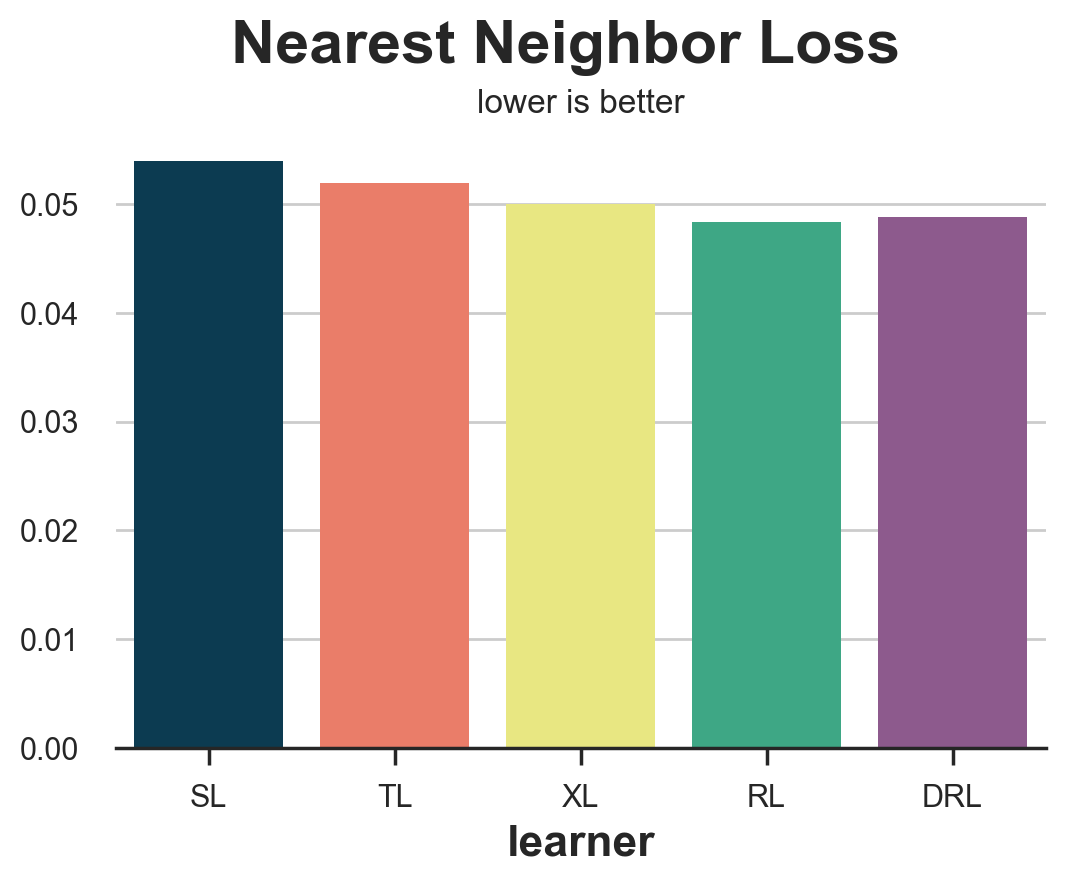

In [32]:
compare_methods(learners, names, loss_nn, title='Nearest Neighbor Loss')

### IPW Loss

In [33]:
def loss_ipw(learner):
    data = generate_data(N=10_000, seed=123)
    tau_hat = learner.effect(data[X])
    e_hat = clone(model_e).fit(data[X], data[W]).predict_proba(data[X])[:,1]
    tau_gg = data[Y] * (data[W] - e_hat) / (e_hat * (1 - e_hat))
    return np.mean((tau_hat - tau_gg)**2)

,learner,loss
0,SL,0.447180
1,TL,0.430504
2,XL,0.443729
3,RL,0.439256
4,DRL,0.440603


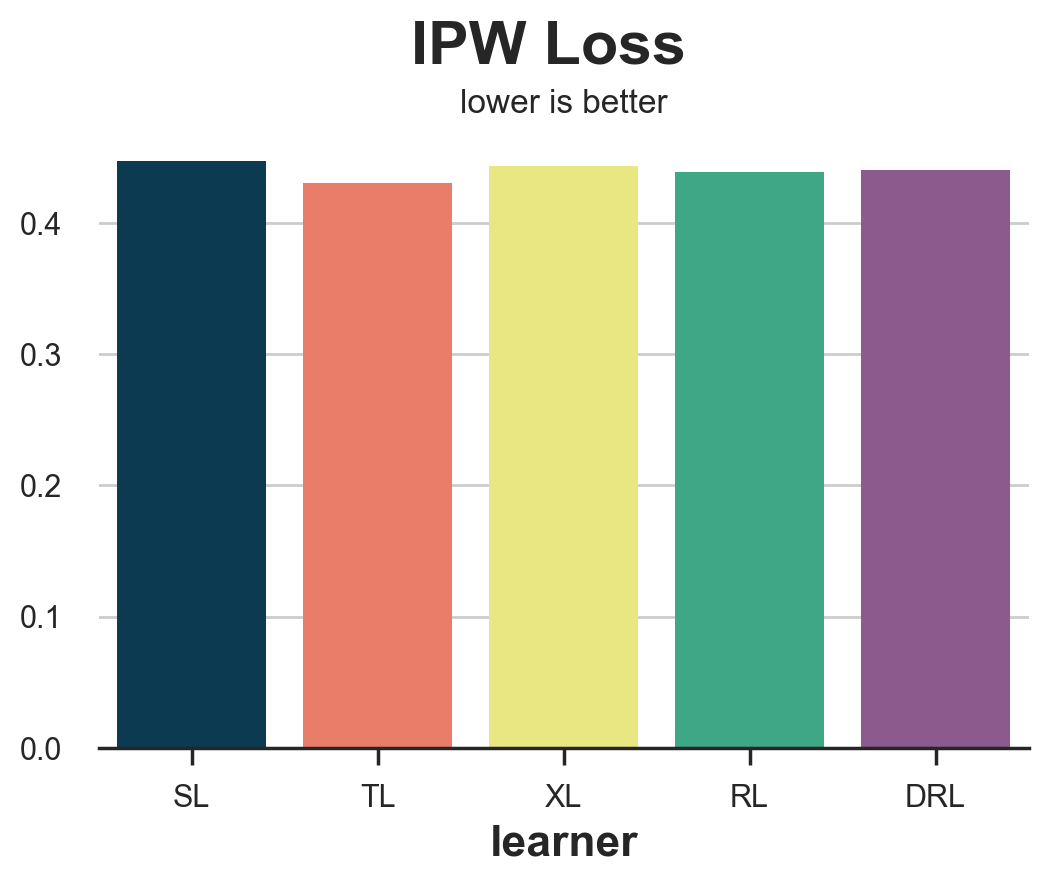

In [34]:
compare_methods(learners, names, loss_ipw, title='IPW Loss')

### R Loss

In [35]:
def loss_r(learner):
    data = generate_data(N=10_000, seed=123)
    tau_hat = learner.effect(data[X])
    y_hat = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]])
    e_hat = clone(model_e).fit(df[X], df[W]).predict_proba(data[X])[:,1]
    tau_nw = (data[Y] - y_hat) / (data[W] - e_hat)
    return np.mean((tau_hat - tau_nw)**2)

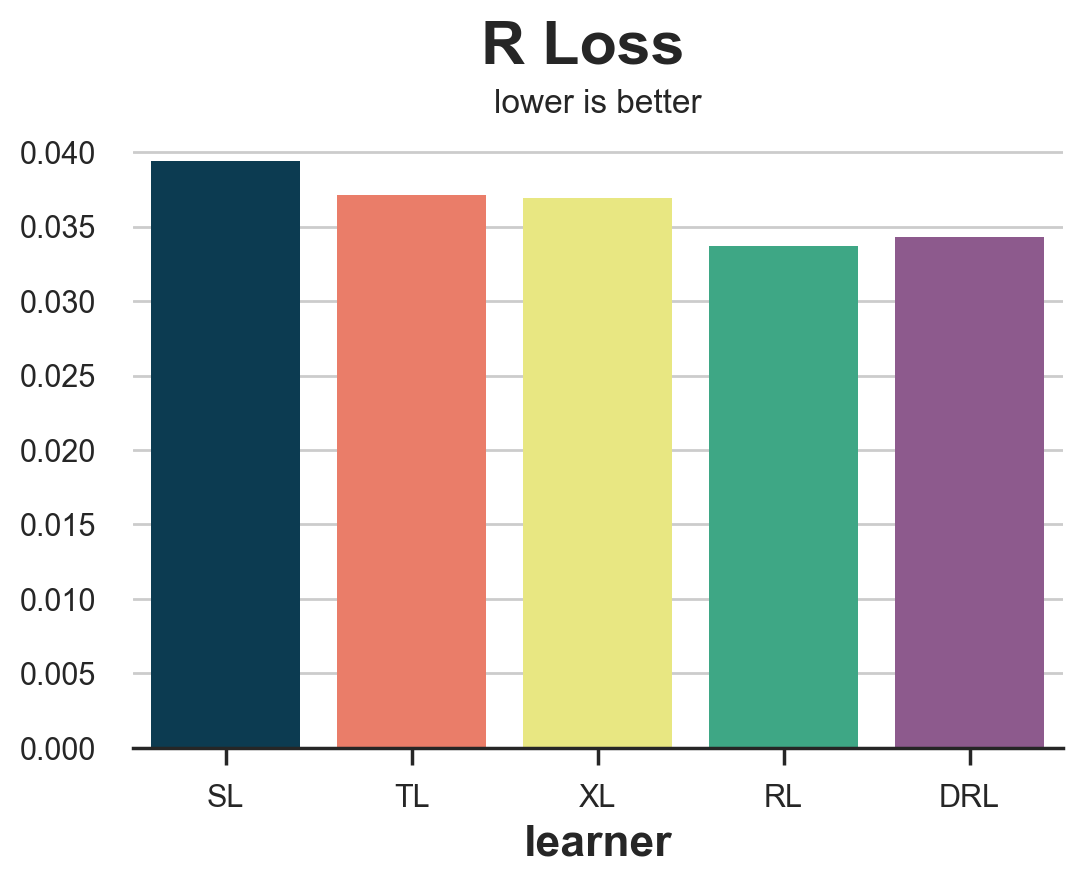

In [36]:
results = compare_methods(learners, names, loss_r, title='R Loss')

### DR Loss

In [37]:
def loss_dr(learner):
    data = generate_data(N=10_000, seed=123)
    tau_hat = learner.effect(data[X])
    y_hat = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]])
    mu1 = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]].assign(mail=1))
    mu0 = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]].assign(mail=1))
    e_hat = clone(model_e).fit(df[X], df[W]).predict_proba(data[X])[:,1]
    tau_nw = mu1 - mu0 + (data[Y] - y_hat) * (data[W] - e_hat) / (e_hat * (1 - e_hat))
    return np.mean((tau_hat - tau_nw)**2)

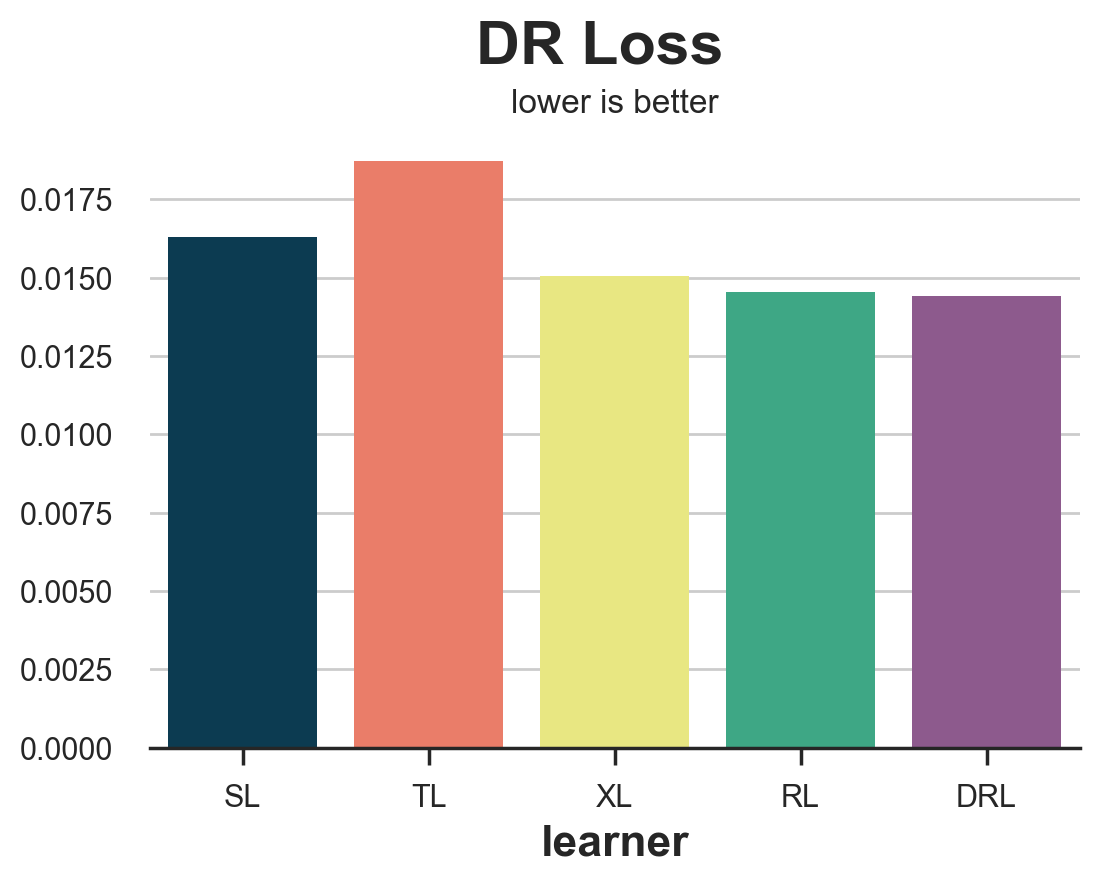

In [38]:
results = compare_methods(learners, names, loss_dr, title='DR Loss')

### HM 2018

In [39]:
def loss_hm(learner):
    data = generate_data(N=10_000, seed=123)
    tau_hat = learner.effect(data[X])
    e_hat = clone(model_e).fit(data[X], data[W]).predict_proba(data[X])[:,1]
    d = tau_hat > 0
    return np.sum((d * data[W] / e_hat + (1-d) * (1-data[W]) / (1-e_hat)) * data[Y])

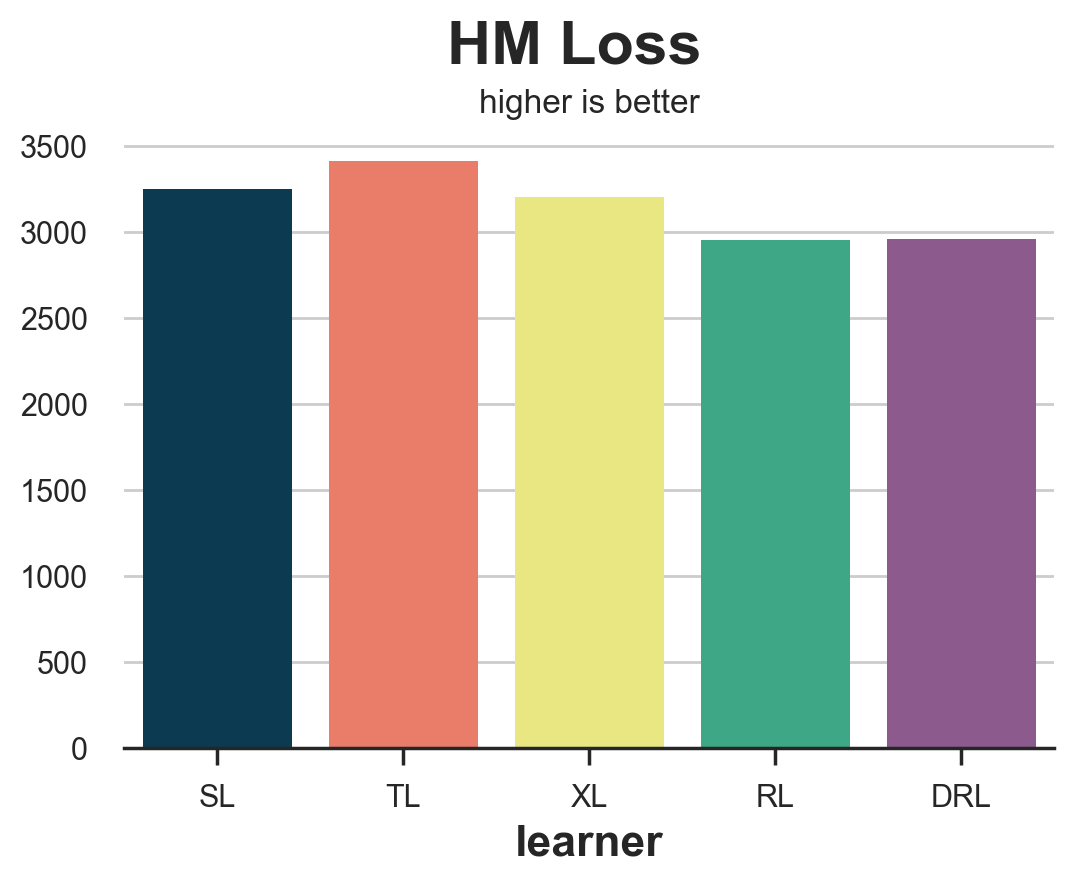

In [40]:
results = compare_methods(learners, names, loss_hm, title='HM Loss', subtitle='higher is better')

## Meta Studies

In this article we have introduced a wide variety of methods to evaluate uplift models, a.k.a. Conditional Average Treatment Effect estimators. We have also tested in our simulated dataset, which is a very special and limited example. How do these metrics **perform** in general? 

[Schuler, Baiocchi, Tibshirani, Shah (2018)](https://arxiv.org/abs/1804.05146) compares the S-loss, T-loss, R-loss, on simulated data, for the corresponding estimators. They find that the R-loss "*is the validation set metric that, when optimized, most consistently leads to the selection of a high-performing model*".

[Curth, van der Schaar (2023)](https://arxiv.org/abs/2302.02923) studies a broader array of learners from a **theoretical perspective**. They find that "*no existing selection criterion is globally best across all experimental conditions we consider*". However, they notice that S- and T-learners tend to perform better when the conditional expectation functions $\mu(X)$ are easier to predict than the CATE $\tau(X)$, while the R- and DR-learners perform better in the opposite scenario. The X-learner performs best when both functions are equally complex. The **intuition** is that the S- and T- learner focus of modeling $y$, while the R- and DR- learner focus on modeling $\tau$.

[Mahajan, Mitliagkas, Neal, Syrgkanis (2023)](https://arxiv.org/abs/2211.01939) is the **most comprehensive** study in terms of scope. The authors compare many metrics on 144 datasets and 415 estimators. They find that “*no metric significantly dominates the rest*” but “*metrics that use DR elements seem to always be among the candidate winners*”/

## Conclusion

TBD

### References

- [Schuler, Baiocchi, Tibshirani, Shah (2018)](https://arxiv.org/abs/1804.05146)

- [Curth, van der Schaar (2023)](https://arxiv.org/abs/2302.02923)

- [Mahajan, Mitliagkas, Neal, Syrgkanis (2023)](https://arxiv.org/abs/2211.01939)

### Related Articles

- [Understanding Meta Learners](https://towardsdatascience.com/8a9c1e340832)

- [Understanding AIPW, the Doubly-Robust Estimator](https://towardsdatascience.com/ed4097dab27a)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/eval_uplift.ipynb